# Transformers

This notebook was created before the .py runner, and is only kept to understand each step of this approach, but to run the different tests and read the code please use the runners.
The runner is up to date, this version is not. Additionally, results obtained in the report were obtained with the runners and not the notebooks

In [36]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import torch
from torchtune.datasets import ConcatDataset
import optuna
import lightning.pytorch as pl
from electricity_price_forecast.data.dataset import DatasetWithWindow
from electricity_price_forecast.model.lstm_model import LSTMModel
from electricity_price_forecast.model.torch_lightning_module import TorchLightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from electricity_price_forecast.data.datamodule import Datamodule
from electricity_price_forecast.data.data_visualization import plot_prices, plot_predictions_vs_real
import logging
from electricity_price_forecast.model.lstm_model import MULTI_STEP
from electricity_price_forecast.data.data_processing import transform_synthetic_data_optimized, preprocess_true_data, preprocess_synthetic_data, DataNormalizer, get_predict_data, get_splits

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

VAL_RATIO = 0.2
TESTED_HORIZONS = [6, 12, 24, 48, 72, 168]

In [37]:
df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet")
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

print(df_price.index.min())
print(df_price.index.max())
df_price.head()

2016-12-31 23:00:00+00:00
2020-12-31 22:00:00+00:00


,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [38]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [39]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,58.82,2016-12-31 23:00:00+00:00,5,23,366,0,31,12,2016,0
1,58.23,2017-01-01 00:00:00+00:00,6,0,1,1,1,1,2017,1
2,51.95,2017-01-01 01:00:00+00:00,6,1,1,1,1,1,2017,2
3,47.27,2017-01-01 02:00:00+00:00,6,2,1,1,1,1,2017,3
4,45.49,2017-01-01 03:00:00+00:00,6,3,1,1,1,1,2017,4


In [40]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,31.66,2016-12-31 00:00:00+00:00,5,0,366,0,31,12,2016,0
1,31.06,2016-12-31 01:00:00+00:00,5,1,366,0,31,12,2016,1
2,27.81,2016-12-31 02:00:00+00:00,5,2,366,0,31,12,2016,2
3,27.54,2016-12-31 03:00:00+00:00,5,3,366,0,31,12,2016,3
4,25.04,2016-12-31 04:00:00+00:00,5,4,366,0,31,12,2016,4


## Plot data

Epoch 21:  19%|█▉        | 13/69 [02:54<12:32,  0.07it/s, train_loss=7.530, val_loss=15.80] 


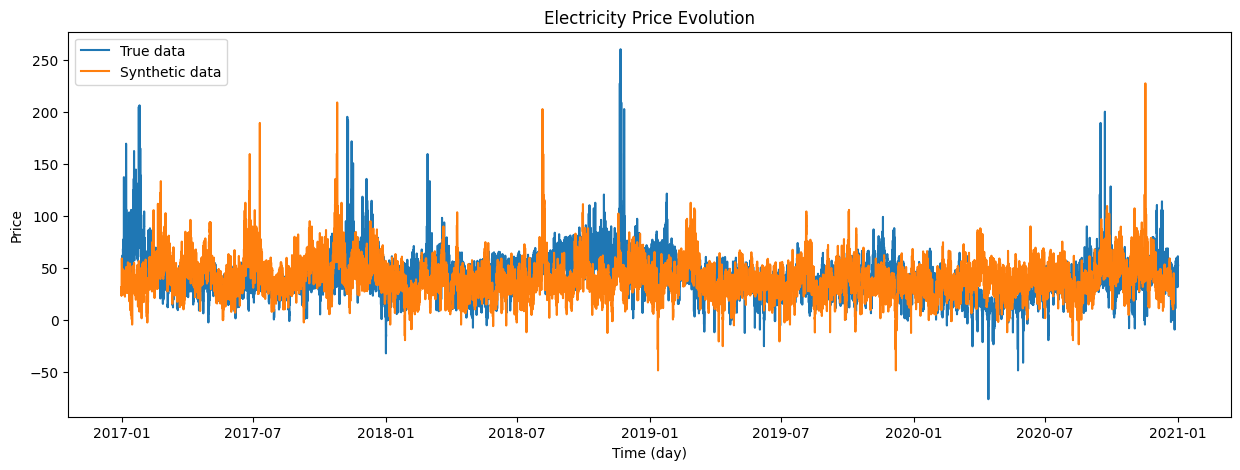

In [41]:
plot_prices([df_price_preprocessed, df_price_generated_00257_preprocessed], ["True data", "Synthetic data"])

## Without data augmentation

In [42]:
window_size = 12
window_step = min(TESTED_HORIZONS[4], window_size)
horizon = TESTED_HORIZONS[4]
features = ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"]
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, features, "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

# splits
train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [43]:
from electricity_price_forecast.model.transformers_model import TransformersModel

def get_best_params(datamodule, horizon, n_trials=50):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: train_model(
        datamodule,
        horizon,
        lr=trial.suggest_float("lr", 1e-5, 1e-1),
        n_epochs=30,
        n_layers=trial.suggest_int("n_layers", 1, 10),
    )[-1]["val_loss"], n_trials=n_trials)
    return study.best_params


def train_model(datamodule, horizon, early_stopping=False, num_heads=1, lr=0.001, n_epochs=50, n_layers=1, device="cuda"):
    train_dataloader = datamodule.train_dataloader()
    X_batch, _ = next(iter(train_dataloader))
    input_dim = X_batch.shape[-1]
    
    model_params = {
        "input_dim": input_dim,
        "n_layers": n_layers,
        "output_dim": horizon,
        "num_heads": num_heads,
    }
    
    model = TorchLightningModule(TransformersModel, model_params, lr=lr, device=device)
    
    if early_stopping:
        callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False)]
    else:
        callbacks = []
        
    if device == "cuda":
        trainer = pl.Trainer(max_epochs=n_epochs, devices=-1, accelerator="cuda", callbacks=callbacks, enable_checkpointing=False, logger=False)
    else:
        trainer = pl.Trainer(max_epochs=n_epochs, callbacks=callbacks, enable_checkpointing=False, logger=False)
    
    trainer.fit(model, datamodule)
            
    return model, {"val_loss": trainer.callback_metrics["val_loss"], "train_loss": trainer.callback_metrics["train_loss"]}

def eval_model(model, dataloader, device="cuda"):
    predictions = []
    ground_truth = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    return TorchLightningModule.get_test_metrics(predictions, ground_truth)

def predict(model, x, device="cuda"):
    model.eval()
    model.to(device)
    y_pred = None
    
    with torch.no_grad():
        y_pred = model(x)
    
    return y_pred

In [44]:
# best_params = get_best_params(datamodule, horizon, n_trials=3)

In [45]:
best_params = {'lr': 0.08914550925407072, 'n_layers': 4}
best_params

{'lr': 0.08914550925407072, 'n_layers': 4}

In [46]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 69/69 [00:01<00:00, 38.35it/s, train_loss=8.330, val_loss=11.00]


100%|██████████| 6/6 [00:00<00:00, 122.34it/s]

Results: {'mse': 440.79632568359375, 'mae': 17.137351989746094, 'rmse': 20.995149612426758}


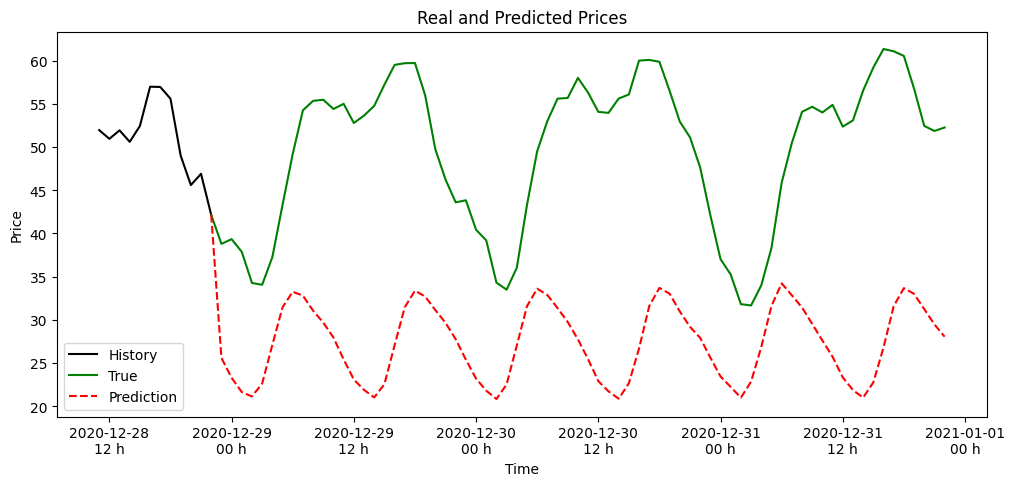

In [47]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

## With provided data augmentation (synthetic data)

In [48]:
def load_synthetic_datasets(path, window_size, window_step, horizon, max_num_fetched=None):
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_all.append(DatasetWithWindow(df_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price"))
    
    return train_all

In [49]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, window_size, window_step, horizon, 3)

  2%|▏         | 3/154 [00:00<00:03, 42.55it/s]


In [50]:
train_concat = ConcatDataset(train_all)

train_split_size = int(len(train_concat)*(1-VAL_RATIO))
val_split_size = len(train_concat) - train_split_size

train_split, val_split, _ = get_splits(train_concat, 0, VAL_RATIO)

predict_dates, predict_y, predict_x = get_predict_data(test_split)

# test_split is the same (we don't want to test on synthetic data)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

#### Find best params

In [51]:
# best_params = get_best_params(datamodule, horizon, n_trials=20)

In [52]:
best_params = {'lr': 0.08914550925407072, 'n_layers': 4}
best_params

{'lr': 0.08914550925407072, 'n_layers': 4}

In [53]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/218 [00:00<?, ?it/s] 

Epoch 5: 100%|██████████| 218/218 [00:05<00:00, 39.26it/s, train_loss=10.20, val_loss=11.90]


100%|██████████| 6/6 [00:00<00:00, 171.41it/s]

Results: {'mse': 232.13975524902344, 'mae': 10.574252128601074, 'rmse': 15.236133575439453}


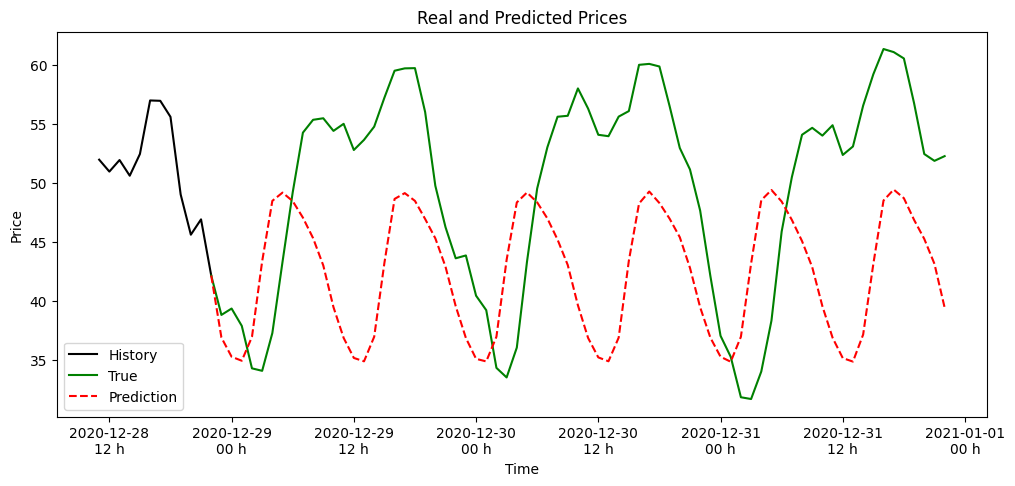

In [54]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions)

## With Normalization

In [55]:
data_normalizer = DataNormalizer()
df_price_preprocessed_normalized = data_normalizer.transform_df(df_price_preprocessed)
df_price_preprocessed_normalized.head()

,price,date,dayofweek,hourofday,dayofyear,dayofseries,dayofmonth,month,year,hourofseries
0,0.400989,2016-12-31 23:00:00+00:00,0.833333,1.000000,1.0,0.000000,1.0,1.0,0.00,0.000000
1,0.399232,2017-01-01 00:00:00+00:00,1.000000,0.000000,0.0,0.000684,0.0,0.0,0.25,0.000029
2,0.380528,2017-01-01 01:00:00+00:00,1.000000,0.043478,0.0,0.000684,0.0,0.0,0.25,0.000057
3,0.366590,2017-01-01 02:00:00+00:00,1.000000,0.086957,0.0,0.000684,0.0,0.0,0.25,0.000086
4,0.361289,2017-01-01 03:00:00+00:00,1.000000,0.130435,0.0,0.000684,0.0,0.0,0.25,0.000114


In [56]:
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed_normalized, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofmonth", "month", "year", "price"], "price")
# dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, "price", "price")

train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)
predict_dates, predict_y, predict_x = get_predict_data(test_split)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=32)

In [57]:
# best_params = get_best_params(datamodule, horizon, n_trials=3)

In [58]:
best_params = {'lr': 0.04016963835331307, 'n_layers': 6}
best_params

{'lr': 0.04016963835331307, 'n_layers': 6}

In [59]:
model, _ = train_model(datamodule, horizon, n_epochs=20, early_stopping=True, **best_params)

d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 69/69 [00:02<00:00, 28.97it/s, train_loss=0.0437, val_loss=0.0578]


100%|██████████| 6/6 [00:00<00:00, 115.19it/s]

Results: {'mse': 0.002483439864590764, 'mae': 0.03682103753089905, 'rmse': 0.049834124743938446}


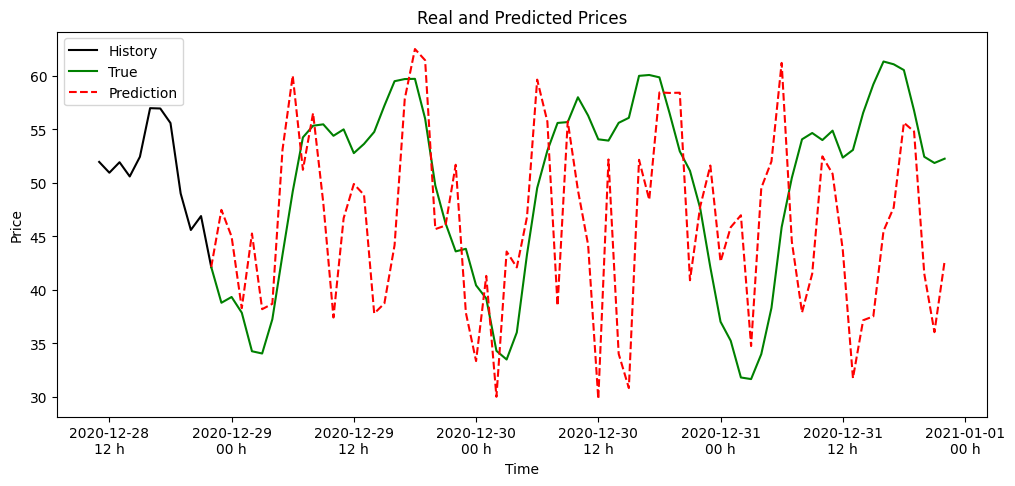

In [60]:
test_dataloader = datamodule.test_dataloader()
results = eval_model(model, test_dataloader)
print("Results:", results)

# add dim before for batch
predictions = predict(model, predict_x.unsqueeze(0), device="cuda")
# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(predict_dates, predict_y, predictions, data_normalizer)